#**Librairies Importation**

In [0]:
#Data Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import Deep Learning librairies

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Sampling
from sklearn.model_selection import train_test_split

# **DATA IMPORTATION & SHAPING**

In [0]:
train = pd.read_csv('train.csv').drop('label',axis =1)
label = pd.read_csv('train.csv')['label']
test = pd.read_csv('test.csv')

Let's check the distribution of the labels to see if we need to make a smart sampling(upsampling, downsampling, smote, etc)

In [0]:
label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

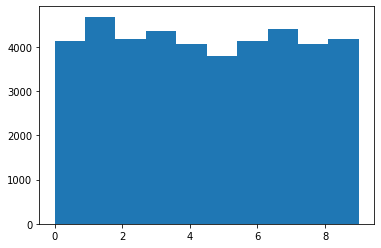

In [0]:
plt.hist(label)

As we can see, the data is well distributed. Hence, we can work on the label dataset with no specific sampling.

In [0]:
#Normalization

train = train/255
test = test/255

#Reshape to create images 28x28x1

train = train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

First question to ask: Which model do I use?
It is obvious that Deep Learning is more adapted and research papers and articles on the net suggests that CNN is a very common model for such topic. Then, I will implement a **CNN on Tensorflow 2.0**.

To have a concise notebook, I have chosen this time to implement what I consider being the most important steps. Here I will discuss details I have worked on but didn't choose to put them in the Notebook:

* For the optimizer, I have chosen **Adam optimizer** as I have tried **RMSprop** (*lower accuracy by ~ 1%*) & **AdaDelta** (*very slow to converge*)

* In researchs I have made, the pool size = (2,2) is common and we don't need to change it

* To avoid overfitting, I have chosen to work for the first time to **Dropout**

* For the cross validation, I choose a **5-fold (80%/20%)**

* The number of Conv2D, I have tried one, two or three. One Conv2D was not efficient and three Conv2D were less efficient than two Conv2D. Then, **[2 Conv2D -> MaxPool2D -> Droupout]** will be used.

* For the number blocks of the last structure, I have to choose between one, two or three **[2 Conv2D -> MaxPool2D -> Droupout]** because bigger structure takes very much time to train. I ran the code with theses structures and I have noticed that one underfits, three overfits. The better structure is: **[2 Conv2D -> MaxPool2D -> Droupout]*2**

* At the end of **[2 Conv2D -> MaxPool2D -> Droupout]*2**, I choose to put a fully connected structure, I have implemented the CNN with one, two or three hidden layers. One was the more efficent.

Now, I will just check how much **Data Augmentation** makes the model more robust. So I will use the optimized CNN that I found with Grid Search on Data augmented dataset (you can check it on the code: *architecture_optimization.ipynb*)

# **Model with no Data Augmentation / Adam / SCE**

Train on 33600 samples, validate on 8400 samples
Epoch 1/8
33600/33600 - 510s - loss: 0.3360 - acc: 0.8932 - val_loss: 0.0778 - val_acc: 0.9777
Epoch 2/8
33600/33600 - 506s - loss: 0.1045 - acc: 0.9683 - val_loss: 0.0565 - val_acc: 0.9840
Epoch 3/8
33600/33600 - 504s - loss: 0.0787 - acc: 0.9775 - val_loss: 0.0439 - val_acc: 0.9855
Epoch 4/8
33600/33600 - 502s - loss: 0.0599 - acc: 0.9824 - val_loss: 0.0360 - val_acc: 0.9895
Epoch 5/8
33600/33600 - 507s - loss: 0.0517 - acc: 0.9852 - val_loss: 0.0382 - val_acc: 0.9889
Epoch 6/8
33600/33600 - 509s - loss: 0.0472 - acc: 0.9854 - val_loss: 0.0344 - val_acc: 0.9904
Epoch 7/8
33600/33600 - 506s - loss: 0.0419 - acc: 0.9877 - val_loss: 0.0323 - val_acc: 0.9908
Epoch 8/8
33600/33600 - 508s - loss: 0.0353 - acc: 0.9894 - val_loss: 0.0313 - val_acc: 0.9918


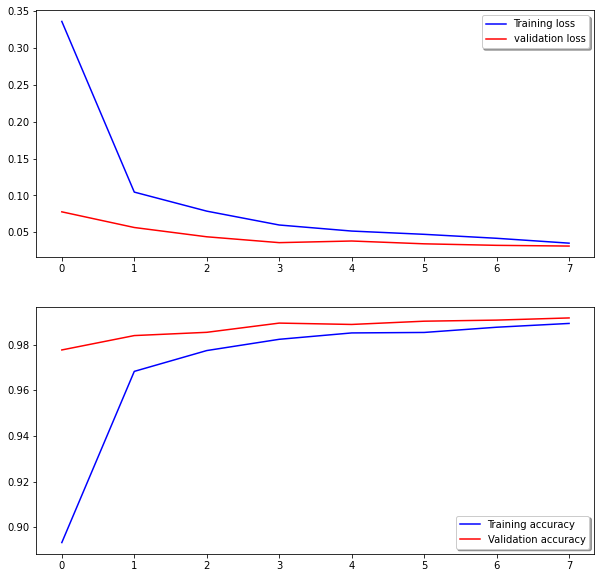

In [0]:
# Define CNN:
#[Conv2D->relu]*2 with n filters -> MaxPool2D (2,2) -> Dropout -> 
#[Conv2D->relu]*2 with m filters -> MaxPool2D (2,2) -> Dropout ->
#Flatten -> Dense with p nodes -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax")) #10 possible outputs because it is a 10-class problem

# Compile the model
model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

epochs = 8
batch_size = 100

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(train, label, test_size = 0.2, random_state=2)

# Without data augmentation: accuracy of 0.98971 on Kaggle
history_CNN_adam = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val), verbose = 2)

training_loss = history_CNN_adam.history['loss']
validation_loss = history_CNN_adam.history['val_loss']
training_acc = history_CNN_adam.history['acc']
validation_acc = history_CNN_adam.history['val_acc']

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(training_loss, color='b', label="Training loss")
ax[0].plot(validation_loss, color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(training_acc, color='b', label="Training accuracy")
ax[1].plot(validation_acc, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# predict results
sub = model.predict(test)

# select the indix with the maximum probability
sub = np.argmax(sub,axis = 1)

sub_df = pd.Series(sub,name="Label")

submission = pd.concat([pd.Series(range(1,test.shape[0]+1), name = "ImageId"), sub_df],axis = 1)

submission.to_csv("ismail_CNN_nda_adam_sce_conv_64.csv",index=False)

When I submit the result on Kaggle, I get: 0.98985 accuracy and the CV accuracy is 0.9918.

# **Model with Data Augmentation / Adam / SCE**

In [0]:
# Define CNN:
#[Conv2D->relu]*2 with n filters -> MaxPool2D (2,2) -> Dropout -> 
#[Conv2D->relu]*2 with m filters -> MaxPool2D (2,2) -> Dropout ->
#Flatten -> Dense with p nodes -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax")) #10 possible outputs because it is a 10-class problem

# Compile the model
model.compile(optimizer = 'Adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

epochs = 8
batch_size = 100

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(train, label, test_size = 0.2, random_state=2)

# Manual data augmentation

datagen = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.2
                             )

datagen.fit(X_train)

training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

# With data augmentation: accuracy of 0.9920 on Kaggle

for e in range(1,epochs+1):

    print('Epoch', e)
    batches = 0

    for x_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=batch_size):

        x_train, x_val, y_train, y_val = train_test_split(x_batch, y_batch, test_size = 0.2, random_state=2)
        history_CNN_adam_da = model.fit(X_train, Y_train, validation_data = (X_val, Y_val))
        training_loss.append(history_CNN_adam_da.history['loss'])
        validation_loss.append(history_CNN_adam_da.history['val_loss'])
        training_acc.append(history_CNN_adam_da.history['acc'])
        validation_acc.append(history_CNN_adam_da.history['val_acc'])
        batches += 1

        if batches >= 1:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

Epoch 1
Train on 33600 samples, validate on 8400 samples
33600/33600 [==============================] - 512s 15ms/sample - loss: 0.2483 - acc: 0.9201 - val_loss: 0.0774 - val_acc: 0.9771
Epoch 2
Train on 33600 samples, validate on 8400 samples
33600/33600 [==============================] - 514s 15ms/sample - loss: 0.0922 - acc: 0.9736 - val_loss: 0.0526 - val_acc: 0.9843
Epoch 3
Train on 33600 samples, validate on 8400 samples
33600/33600 [==============================] - 514s 15ms/sample - loss: 0.0706 - acc: 0.9789 - val_loss: 0.0363 - val_acc: 0.9896
Epoch 4
Train on 33600 samples, validate on 8400 samples
33600/33600 [==============================] - 512s 15ms/sample - loss: 0.0581 - acc: 0.9831 - val_loss: 0.0386 - val_acc: 0.9886
Epoch 5
Train on 33600 samples, validate on 8400 samples
33600/33600 [==============================] - 513s 15ms/sample - loss: 0.0510 - acc: 0.9844 - val_loss: 0.0343 - val_acc: 0.9905
Epoch 6
Train on 33600 samples, validate on 8400 samples
33600/33

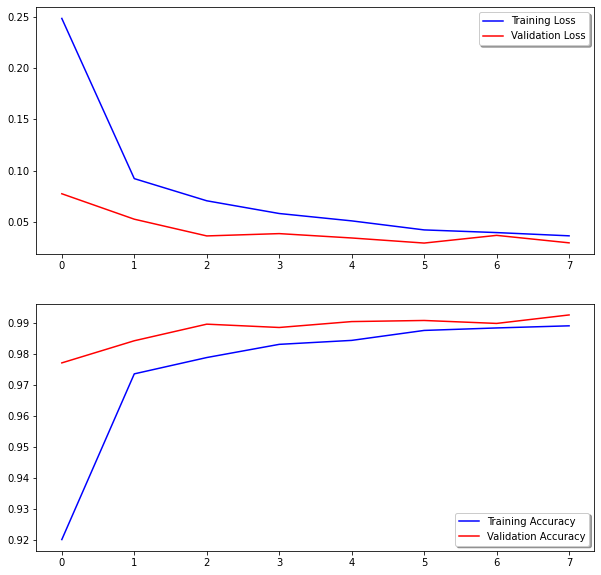

In [0]:
# Plot the loss and accuracy curves for training and validation

training_loss = np.array(training_loss)
validation_loss = np.array(validation_loss)
training_acc = np.array(training_acc)
validation_acc = np.array(validation_acc)

fig, ax = plt.subplots(2,1,figsize=(10,10))

#Plot loss curves

ax[0].plot(training_loss, color='b', label="Training Loss")
ax[0].plot(validation_loss, color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Plot accuracy curves
ax[1].plot(training_acc, color='b', label="Training Accuracy")
ax[1].plot(validation_acc, color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
# predict results
sub = model.predict(test)

# Takes the maximum probability digit
sub = np.argmax(sub,axis = 1)

#Build pandas Dataframe
sub_df = pd.Series(sub,name="Label")
submission = pd.concat([pd.Series(range(1,test.shape[0]+1), name = "ImageId"), sub_df],axis = 1)

#Save csv submission file to submit prediction of Kaggle
submission.to_csv("ismail_CNN_da_adam_sce_optimal_conv_8.csv",index=False)

When I submit the result on Kaggle, I get: 0.99200 accuracy and the CV accuracy 0.9926. Here, I end my 2 days job. Thanks for reading !

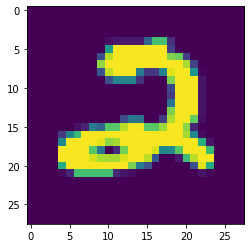

In [0]:
plt.imshow(test[0][:,:,0])

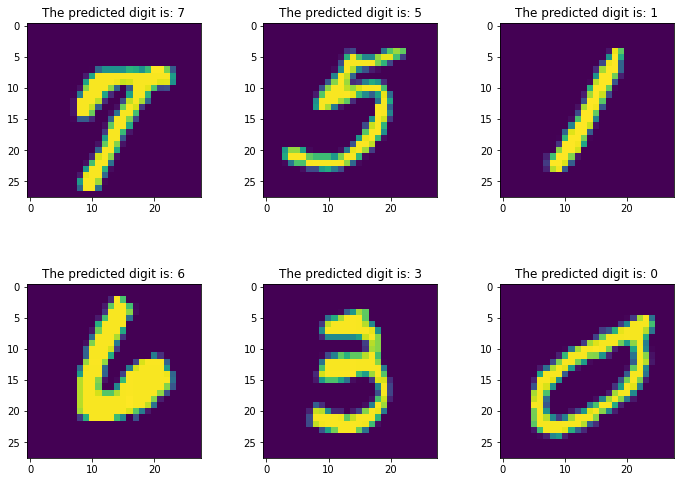

<Figure size 432x288 with 0 Axes>

In [0]:
import random 

ax = []
fig = plt.figure(figsize=(12, 8))

for i in range(1,7):
    random_number = random.randrange(1, 20001, 1)
    img = test[random_number][:,:,0]
    # create subplot and append to ax
    ax.append( fig.add_subplot(2, 3, i) )
    ax[-1].set_title("The predicted digit is: " + str(sub[random_number]))
    plt.subplots_adjust(hspace=0.5) 
    plt.imshow(img)

plt.show()

References & inspirations:
* *Recognition of Handwritten Digit using
Convolutional Neural Network in Python with
Tensorflow and Comparison of Performance for
Various Hidden Layers* by Fathma Siddique,Shadman Sakib & Md. Abu Bakr Siddique: https://arxiv.org/ftp/arxiv/papers/1909/1909.08490.pdf
* *How to choose CNN Architecture MNIST* by Chris Deotte: https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
* *Introduction to CNN Keras - 0.997 (top 6%)* by Yassine Ghouzam: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
